# Laboratorio 5

Daniel Alfredo Rayo Roldán

Gerardo Gabriel Pineda Riveiro

Github: https://github.com/DanielRasho/DS-Lab4

In [110]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import openeo
import re
from pathlib import Path
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Grupo de datos

Se estará trabajando con 14 muestras de imagenes recolectadas por el Sentinel 2, entre enero y agosto de 2025. Estas 14 muestras pertenecen a los lagos de Amatitlán y Atitlán. Dada la naturaleza impredecible del clima se obtuvieron muestras de los días donde la nubosidad era menor al 30%, sin embargo esto causo que los datos estuvieran separados unos de otros a intervalos de tiempos no uniformes. A continuación se muestra las muestras con las que se va a trabajar.

In [47]:
amatitlan_images = {
    '2025-01-13': { 'file': 'cianobacteria_amatitlan-2025-01-13.tif', 'temp' : 24.44},    
    '2025-01-18': { 'file': 'cianobacteria_amatitlan-2025-01-18.tif', 'temp' : 24.44},    
    '2025-02-07': { 'file': 'cianobacteria_amatitlan-2025-02-07.tif', 'temp' : 25.55},    
    '2025-03-04': { 'file':'cianobacteria_amatitlan-2025-03-04.tif', 'temp' : 26.66},    
    '2025-03-19': { 'file':'cianobacteria_amatitlan-2025-03-19.tif', 'temp' : 26.66},
    '2025-03-24': { 'file':'cianobacteria_amatitlan-2025-03-24.tif', 'temp' : 26.66},
    '2025-04-13': { 'file':'cianobacteria_amatitlan-2025-04-13.tif', 'temp' : 27.22},
    '2025-04-15': { 'file':'cianobacteria_amatitlan-2025-04-15.tif', 'temp' : 27.22},
    '2025-04-18': { 'file':'cianobacteria_amatitlan-2025-04-18.tif', 'temp' : 27.22},
    '2025-06-14': { 'file':'cianobacteria_amatitlan-2025-06-14.tif', 'temp' : 25.0},
    '2025-07-17': { 'file':'cianobacteria_amatitlan-2025-07-17.tif', 'temp' : 25.0},
    '2025-07-22': { 'file':'cianobacteria_amatitlan-2025-07-22.tif', 'temp' : 25.0},
    '2025-08-01': { 'file':'cianobacteria_amatitlan-2025-08-01.tif', 'temp' : 25.0},
    '2025-08-13': { 'file':'cianobacteria_amatitlan-2025-08-13.tif', 'temp' : 25.0},
}

atitlan_images = {
    '2025-01-13': { 'file':'cianobacteria_amatitlan-2025-01-13.tif', 'temp' : 22.77},
    '2025-01-18': { 'file':'cianobacteria_amatitlan-2025-01-18.tif', 'temp' : 22.77},
    '2025-01-28': { 'file':'cianobacteria_amatitlan-2025-01-28.tif', 'temp' : 22.77},
    '2025-02-02': { 'file':'cianobacteria_amatitlan-2025-02-02.tif', 'temp' : 23.89},
    '2025-02-07': { 'file':'cianobacteria_amatitlan-2025-02-07.tif', 'temp' : 23.89},
    '2025-03-04': { 'file':'cianobacteria_amatitlan-2025-03-04.tif', 'temp' : 25.0},
    '2025-03-09': { 'file':'cianobacteria_amatitlan-2025-03-09.tif', 'temp' : 25.0},
    '2025-03-14': { 'file':'cianobacteria_amatitlan-2025-03-14.tif', 'temp' : 25.0},
    '2025-04-03': { 'file':'cianobacteria_amatitlan-2025-04-03.tif', 'temp' : 25.0},
    '2025-04-13': { 'file':'cianobacteria_amatitlan-2025-04-13.tif', 'temp' : 25.0},
    '2025-04-15': { 'file':'cianobacteria_amatitlan-2025-04-15.tif', 'temp' : 25.0},
    '2025-05-13': { 'file':'cianobacteria_amatitlan-2025-05-13.tif', 'temp' : 24.44},
    '2025-07-12': { 'file':'cianobacteria_amatitlan-2025-07-12.tif', 'temp' : 25.0},
    '2025-07-24': { 'file':'cianobacteria_amatitlan-2025-07-24.tif', 'temp' : 25.0},
    '2025-08-13': { 'file':'cianobacteria_amatitlan-2025-08-13.tif', 'temp' : 23.33},
}

In [51]:
FALLBACK_IDX = {"B02":2,"B03":3,"B04":4,"B05":5,"B07":7,"B08":8,"B8A":9,"B11":11,"B12":12}

def find_idx_by_name(desc, target):
    for i, n in enumerate(desc, start=1):
        if not n:
            continue
        if re.search(fr"\b{target}\b", str(n), flags=re.IGNORECASE):
            return i
    return None

def get_band(ds, arr, desc, code):
    idx = find_idx_by_name(desc, code) or FALLBACK_IDX.get(code)
    if not idx or idx > ds.count:
        raise ValueError(f"No se encontró {code} en {ds.name}")
    return arr[idx-1].astype(np.float32)

def wbi(B04,B03,B02,B08,B11,B12):
    ndvi = (B08 - B04) / (B08 + B04 + 1e-6)
    mndwi = (B03 - B11) / (B03 + B11 + 1e-6)
    ndwi  = (B03 - B08) / (B03 + B08 + 1e-6)
    ndwi_leaves = (B08 - B11) / (B08 + B11 + 1e-6)
    aweish  = B02 + 2.5*B03 - 1.5*(B08 + B11) - 0.25*B12
    aweinsh = 4*(B03 - B11) - (0.25*B08 + 2.75*B11)
    ws = np.zeros(B04.shape, dtype=np.uint8)
    cond_water = (
        (mndwi > 0.42) |
        (ndwi  > 0.40)  |
        (aweinsh > 0.1879) |
        (aweish  > 0.1112) |
        (ndvi < -0.2) |
        (ndwi_leaves > 1)
    )
    ws[cond_water] = 1
    cond_remove = (aweinsh <= -0.03) | (((B11 - B03)/(B11 + B03 + 1e-6) - ndvi) > 0)
    ws[cond_remove] = 0
    return ws

def ndci(B04,B05):
    return (B05 - B04) / (B05 + B04 + 1e-6)

def chl_from_ndci(ndci):
    return 826.57 * ndci**3 - 176.43 * ndci**2 + 19.0 * ndci + 4.071

def normalize(b):
    b_min, b_max = np.percentile(b[b > 0], (2, 98))
    return np.clip((b - b_min) / (b_max - b_min), 0, 1)

def find_band_idx(names, target):
    for i, n in enumerate(names, start=1):
        if not n:
            continue
        if re.search(fr"\b{target}\b", n, flags=re.IGNORECASE):
            return i
    return None

def stretch(img):
    p2, p98 = np.percentile(img[~np.isnan(img)], [2, 98])
    return np.clip((img - p2) / (p98 - p2 + 1e-6), 0, 1)

def cyanobacteria_index(path, show_rgb=False):
    with rasterio.open(path) as ds:
        arr = ds.read().astype(np.float32)
        desc = ds.descriptions or ([""]*ds.count)
        B02 = get_band(ds, arr, desc, "B02")
        B03 = get_band(ds, arr, desc, "B03")
        B04 = get_band(ds, arr, desc, "B04")
        B05 = get_band(ds, arr, desc, "B05")
        B07 = get_band(ds, arr, desc, "B07")
        B08 = get_band(ds, arr, desc, "B08")
        B8A = get_band(ds, arr, desc, "B8A")
        B11 = get_band(ds, arr, desc, "B11")
        B12 = get_band(ds, arr, desc, "B12")

        # Cálculo
        water = wbi(B04,B03,B02,B08,B11,B12)
        ndci_arr = ndci(B04,B05)
        chl_arr = chl_from_ndci(ndci_arr)
        chl_arr = np.clip(chl_arr, 0, 500)

        if not show_rgb :
            return chl_arr
        else: 
            chl_breaks = np.array([0.5,1,2.5,3.5,5,7,8,10,14,18,20,24,28,30,38,45,50,75,90,100,150,250,300,350,450,500])
            chl_colors = np.array([
                [0,0,1.0],[0,0,1.0],[0,59/255,1],[0,98/255,1],
                [15/255,113/255,141/255],[14/255,141/255,120/255],[13/255,141/255,103/255],
                [30/255,226/255,28/255],[42/255,226/255,28/255],[68/255,226/255,28/255],
                [68/255,226/255,28/255],[134/255,247/255,0],[140/255,247/255,0],[205/255,237/255,0],
                [208/255,240/255,0],[208/255,240/255,0],[251/255,210/255,3/255],[248/255,207/255,2/255],
                [134/255,247/255,0],[245/255,164/255,9/255],[240/255,159/255,8/255],[237/255,157/255,7/255],
                [239/255,118/255,15/255],[239/255,101/255,15/255],[239/255,100/255,14/255],[233/255,72/255,21/255]
            ])
            rgb_tc = np.stack([stretch(B04*3), stretch(B03*3), stretch(B02*3)], axis=-1)
            # Aplicar paleta solo en agua
            rgb = rgb_tc.copy()
            wm = water==1
            chl_vals = chl_arr[wm]
            idx = np.searchsorted(chl_breaks, chl_vals, side='right')
            idx = np.clip(idx, 0, len(chl_colors)-1)
            rgb[wm] = chl_colors[idx]
            return rgb

In [52]:
def plot_cyano_grid(basepath, selected_images, cols=4, figsize=(15, 15)):
    n = len(selected_images)
    rows = (n + cols - 1) // cols  # number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, (date, fname) in enumerate(selected_images.items()):
        tif_path = basepath / fname['file']
        rgb = cyanobacteria_index(tif_path, show_rgb=True)  # (3, H, W)

        axes[i].imshow(rgb)
        axes[i].set_title(str(date), fontsize=10)
        axes[i].axis("off")

    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

#### Amatitlán

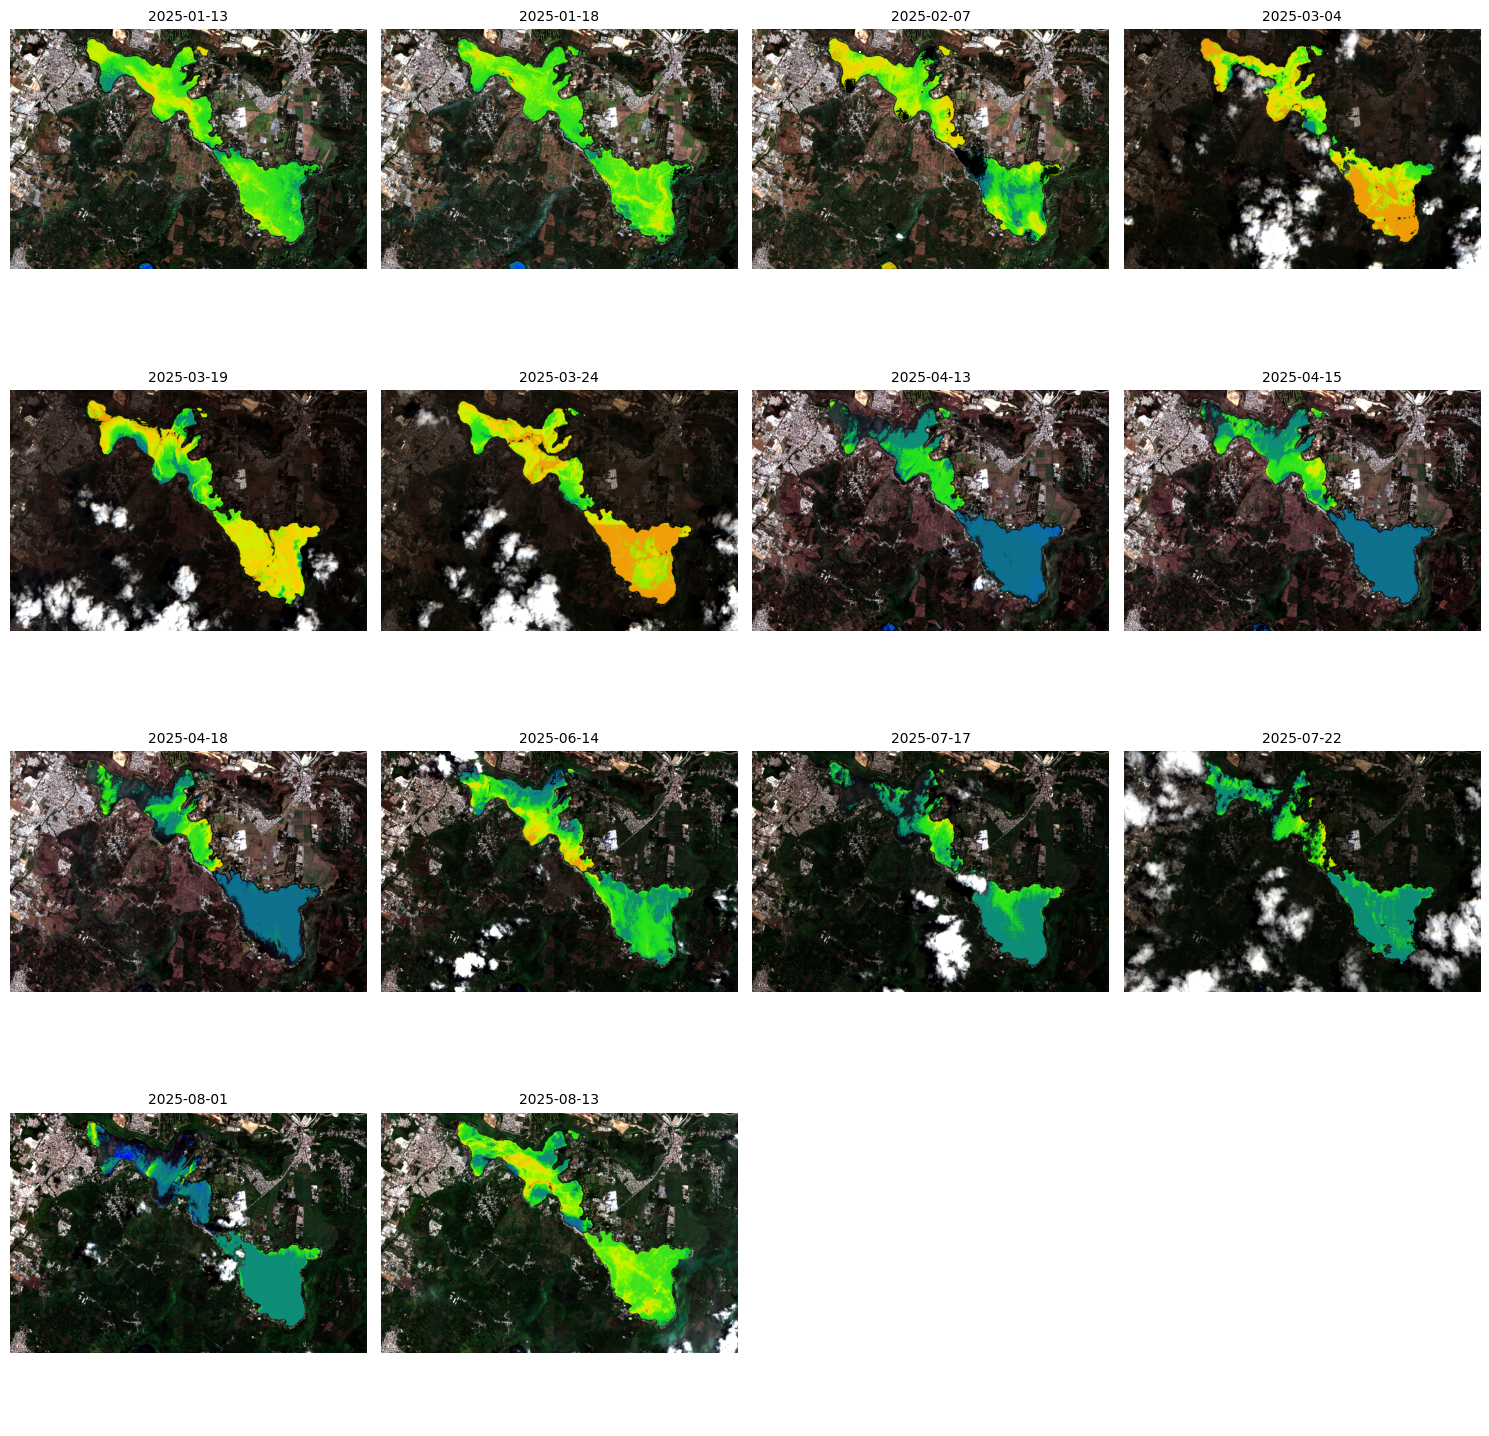

In [53]:
basepath = Path("./data/GIS/")
plot_cyano_grid(basepath, amatitlan_images, cols=4)

#### Atitlán

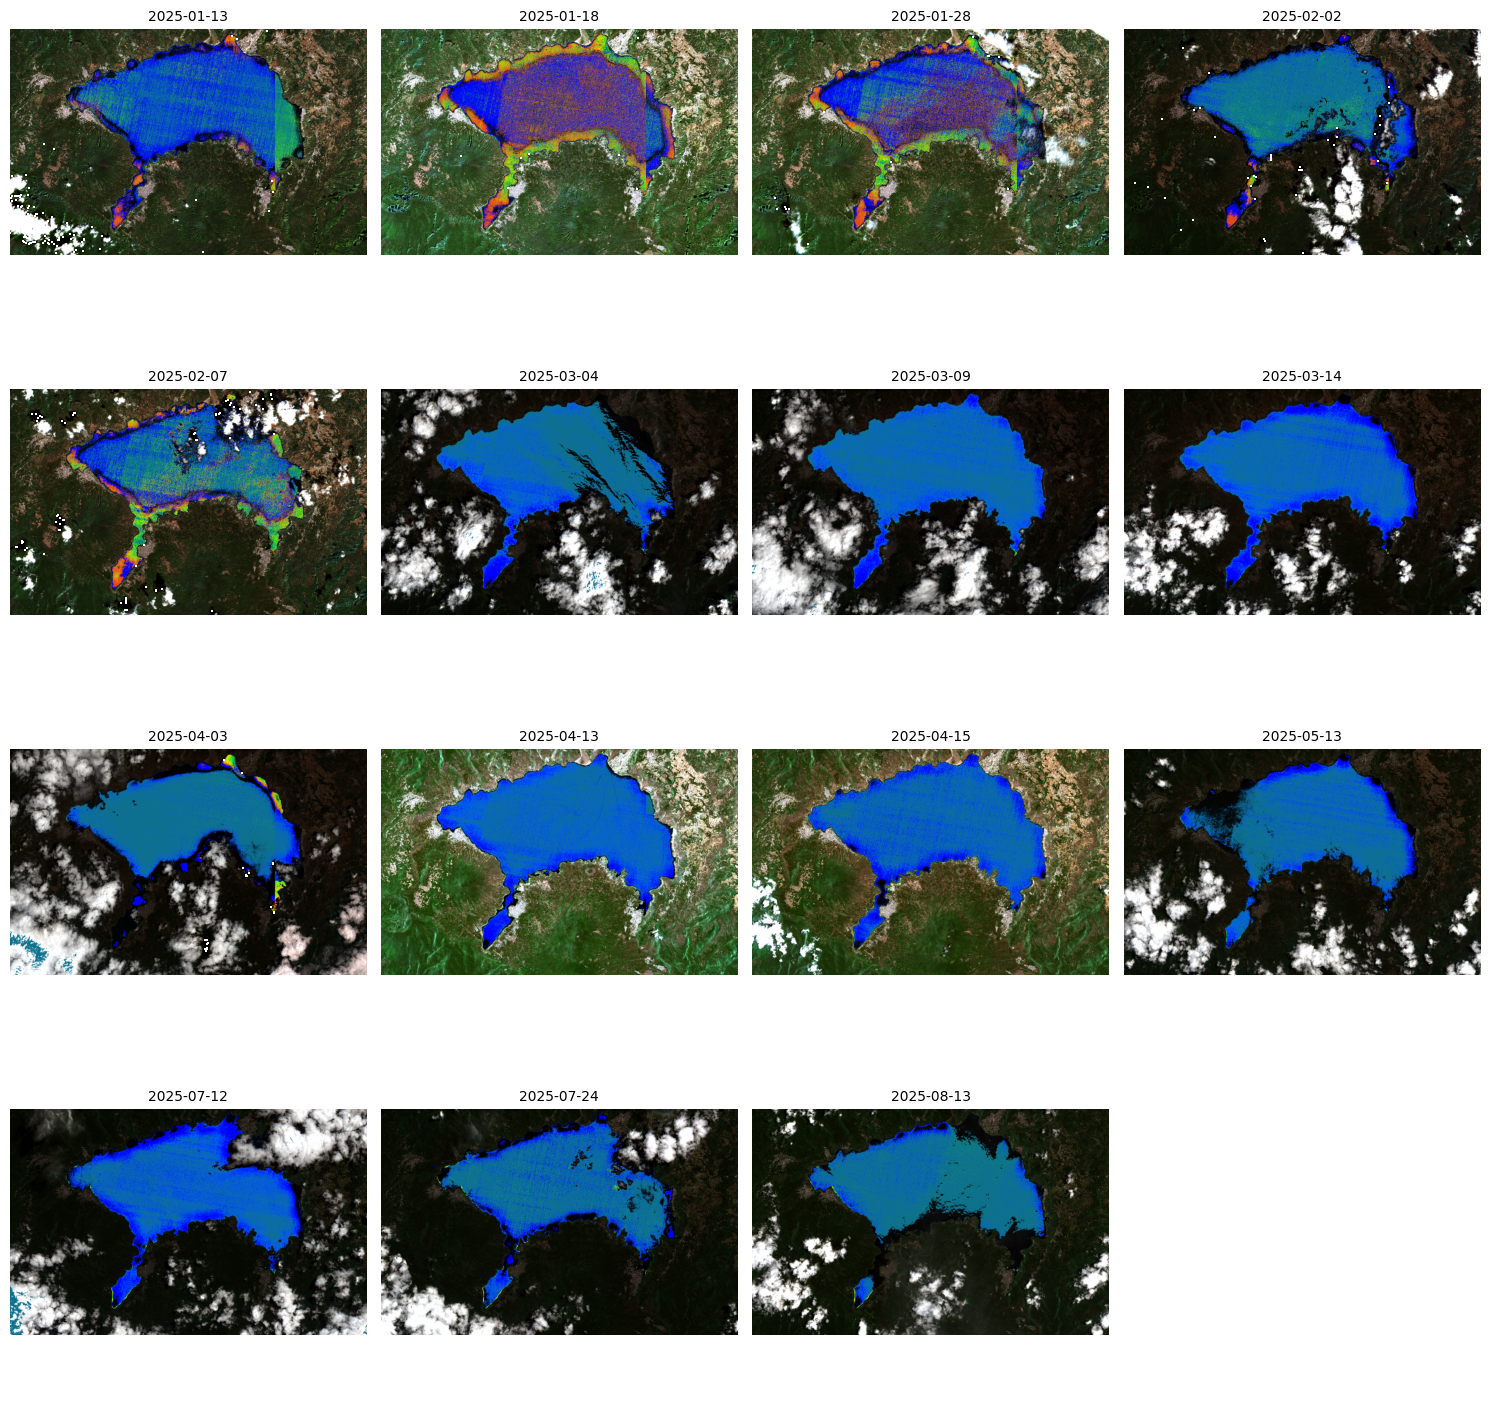

In [54]:
basepath = Path("./data/GISATI/")
plot_cyano_grid(basepath, atitlan_images, cols=4)

# Modelos Temporales

Para el modelo temporal, primero fue necesario procesar los datos originales para calcular el índice promedio de cianobacterias en los lagos en una fecha determinada. Esto después fue almacenado en Dataframes de pandas con los que se entrenarón los modelos.

Además, también se agrego al dataframe otras 2 variables que se utilizarán luego para el entrenamiento de un modelo híbrido: índice de calidad del agua y temperatura promedio.

In [55]:
def water_quality_index(path, show=False):
    # ---------------------------
    # Bands scales
    # ---------------------------
    scaleChl_a = [0, 6, 12, 20, 30, 50]
    scaleCya   = [0, 10, 20, 40, 50, 100]
    scaleTurb  = [0, 4, 8, 12, 16, 20]
    scaleCDOM  = [0, 1, 2, 3, 4, 5]
    scaleDOC   = [0, 5, 10, 20, 30, 40]
    scaleColor = [0, 10, 20, 30, 40, 50]

    def normalize(value, scale):
        min_val, max_val = scale[0], scale[-1]
        norm = (value - min_val) / (max_val - min_val + 1e-10)
        return np.clip(norm, 0, 1)

    def nd_index(a, b):
        return (a - b) / (a + b + 1e-10)

    # ---------------------------
    # Read image bands
    # ---------------------------
    with rasterio.open(path) as ds:
        arr = ds.read().astype(np.float32)  # shape: (bands, height, width)

        # Assuming bands order: B01=0, B02=1, B03=2, B04=3, B08=4
        B01 = arr[0]
        B02 = arr[1]
        B03 = arr[2]
        B04 = arr[3]
        B08 = arr[4]

        # ---------------------------
        # Compute water-land mask
        # ---------------------------
        NDWI = nd_index(B03, B08)

        # ---------------------------
        # Compute water quality parameters
        # ---------------------------
        Chl_a = 4.26 * (B03 / B01)**3.94
        Cya   = 115530.31 * ((B03 * B04) / B02)**2.38
        Turb  = 8.93 * (B03 / B01) - 6.39
        CDOM  = 537 * np.exp(-2.93 * B03 / B04)
        DOC   = 432 * np.exp(-2.24 * B03 / B04)
        Color = 25366 * np.exp(-4.53 * B03 / B04)

        # ---------------------------
        # Normalize
        # ---------------------------
        norm_Chl_a = normalize(Chl_a, scaleChl_a)
        norm_Cya   = normalize(Cya, scaleCya)
        norm_Turb  = normalize(Turb, scaleTurb)
        norm_CDOM  = normalize(CDOM, scaleCDOM)
        norm_DOC   = normalize(DOC, scaleDOC)
        norm_Color = normalize(Color, scaleColor)

        # ---------------------------
        # Combine into a single index
        # ---------------------------
        index_combined = (norm_Chl_a + norm_Cya + norm_Turb +
                          norm_CDOM + norm_DOC + norm_Color) / 6.0

        # Mask land pixels
        index_combined[NDWI < 0] = np.nan

        # ---------------------------
        # Optional display
        # ---------------------------
        if show:
            plt.imshow(index_combined, cmap="viridis")
            plt.colorbar(label="Water Quality Index (0-1)")
            plt.title("Unified Water Quality Index")
            plt.show()

        return index_combined

In [ ]:
dates = []
cianobacteria = []
contamination = []
temperature = []

def getIndexPerDate(basepath, selected_images):
    results = {}
    for date, fname in selected_images.items():
        tif_path = basepath / fname['file']
        with rasterio.open(tif_path) as ds:
            chl_map = cyanobacteria_index(tif_path)
            mean_chl = np.nanmean(chl_map)
            contamination_map = water_quality_index(tif_path)
            mean_contamination = np.nanmean(contamination_map)
            cianobacteria.append(mean_chl)
            contamination.append(mean_contamination)
            dates.append(date)
            temperature.append(fname['temp'])

getIndexPerDate(Path("./data/GIS/"), amatitlan_images)

amatitlan_df = pd.DataFrame.from_dict({'Fecha': dates, 'Indice Cianobacterias': cianobacteria, "Indice Calidad de Agua": contamination, "Temperature": temperature})

In [ ]:
dates = []
cianobacteria = []
contamination = []
temperature = []

def getIndexPerDate(basepath, selected_images):
    results = {}
    for date, fname in selected_images.items():
        tif_path = basepath / fname['file']
        with rasterio.open(tif_path) as ds:
            chl_map = cyanobacteria_index(tif_path)
            mean_chl = np.nanmean(chl_map)
            contamination_map = water_quality_index(tif_path)
            mean_contamination = np.nanmean(contamination_map)
            cianobacteria.append(mean_chl)
            contamination.append(mean_contamination)
            dates.append(date)
            temperature.append(fname['temp'])

getIndexPerDate(Path("./data/GISATI/"), atitlan_images)

atitlan_df = pd.DataFrame.from_dict({'Fecha': dates, 'Indice Cianobacterias': cianobacteria, "Indice Calidad de Agua": contamination,"Temperature": temperature })

A continuación, se encuentran los conjuntos de datos con los que se estará trabajando

#### Amatitlán

In [97]:
amatitlan_df

Fecha  Indice Cianobacterias  Indice Calidad de Agua  Temperature
0  2025-01-13              35.035213                0.607337        24.44
1  2025-01-18              31.754570                0.611615        24.44
2  2025-02-07              32.766125                0.609827        25.55
3  2025-03-04              27.740747                0.681984        26.66
4  2025-03-19              16.521894                0.551836        26.66
5  2025-03-24              25.951715                0.657450        26.66
6  2025-04-13              22.318863                0.661517        27.22
7  2025-04-15              18.958420                0.668408        27.22
8  2025-04-18              17.280611                0.710733        27.22
9  2025-06-14              44.312778                0.637056        25.00
10 2025-07-17              46.248722                0.713878        25.00
11 2025-07-22              39.068951                0.625961        25.00
12 2025-08-01              74.088867                0.713150        25.00
13 2025-08-13              44.819077                0.622907        25.00

#### Atitlán

In [98]:
atitlan_df

Fecha  Indice Cianobacterias  Indice Calidad de Agua  Temperature
0  2025-01-13              55.493599                0.210186        22.77
1  2025-01-18              82.656815                0.266005        22.77
2  2025-01-28              69.421890                0.281620        22.77
3  2025-02-02              56.853024                0.238580        23.89
4  2025-02-07              58.547104                0.274652        23.89
5  2025-03-04              19.610632                0.391104        25.00
6  2025-03-09              11.822133                0.353368        25.00
7  2025-03-14              22.131422                0.280939        25.00
8  2025-04-03              17.893871                0.396244        25.00
9  2025-04-13              35.801998                0.296648        25.00
10 2025-04-15              25.820272                0.210239        25.00
11 2025-05-13              26.955770                0.347231        24.44
12 2025-07-12              36.781078                0.332601        25.00
13 2025-07-24              42.910049                0.244867        25.00
14 2025-08-13              33.182049                0.340590        23.33

### Creación de modelos

#### Amatitlán

In [111]:
# --- Prepare data ---
amatitlan_df["Fecha"] = pd.to_datetime(amatitlan_df["Fecha"])
df = amatitlan_df.set_index("Fecha")["Indice Cianobacterias"]

# Make sure index has a frequency (monthly assumed)
# Split train/test
train, test = df.iloc[:-2], df.iloc[-2:]

# --- Fit Holt-Winters ---
# No seasonality (for now)
model = ExponentialSmoothing(train, trend="add", seasonal=None)
hw_fit = model.fit()

# Forecast for test period
forecast = hw_fit.forecast(len(test))
forecast.index = test.index
print(forecast)

Fecha
2025-08-01    41.020997
2025-08-13    41.596876
dtype: float64


/home/smaug/Documents/DataScience/lab5/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/smaug/Documents/DataScience/lab5/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/smaug/Documents/DataScience/lab5/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [112]:
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)
print("Forecasted vs Actual:")
print(pd.DataFrame({"Actual": test, "Forecast": forecast}))

MAE: 18.145035122139088
RMSE: 23.493260666256745
Forecasted vs Actual:
               Actual   Forecast
Fecha                           
2025-08-01  74.088867  41.020997
2025-08-13  44.819077  41.596876


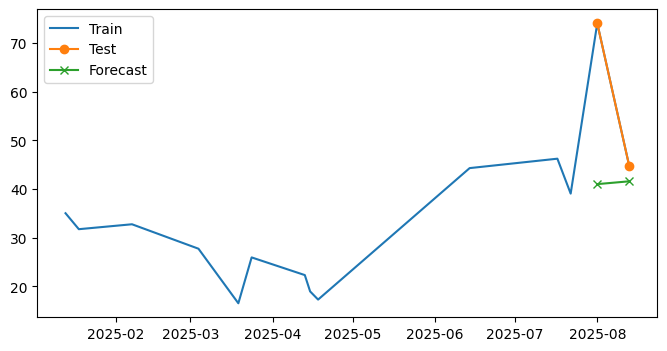

In [113]:
plt.figure(figsize=(8,4))
plt.plot(df.index, df, label="Train")
plt.plot(test.index, test, label="Test", marker="o")
plt.plot(forecast.index, forecast, label="Forecast", marker="x")
plt.legend()
plt.show()

#### Atitlán

In [114]:
# --- Prepare data ---
atitlan_df["Fecha"] = pd.to_datetime(atitlan_df["Fecha"])
df = atitlan_df.set_index("Fecha")["Indice Cianobacterias"]

# Make sure index has a frequency (monthly assumed)
# Split train/test
train, test = df.iloc[:-2], df.iloc[-2:]

# --- Fit Holt-Winters ---
# No seasonality (for now)
model = ExponentialSmoothing(train, trend="add", seasonal=None)
hw_fit = model.fit()

# Forecast for test period
forecast = hw_fit.forecast(len(test))
forecast.index = test.index
print(forecast)

Fecha
2025-07-24    31.708380
2025-08-13    29.430319
dtype: float64


/home/smaug/Documents/DataScience/lab5/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/smaug/Documents/DataScience/lab5/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/smaug/Documents/DataScience/lab5/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [115]:
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)
print("Forecasted vs Actual:")
print(pd.DataFrame({"Actual": test, "Forecast": forecast}))

MAE: 7.4766994767455515
RMSE: 8.353229171459072
Forecasted vs Actual:
               Actual   Forecast
Fecha                           
2025-07-24  42.910049  31.708380
2025-08-13  33.182049  29.430319


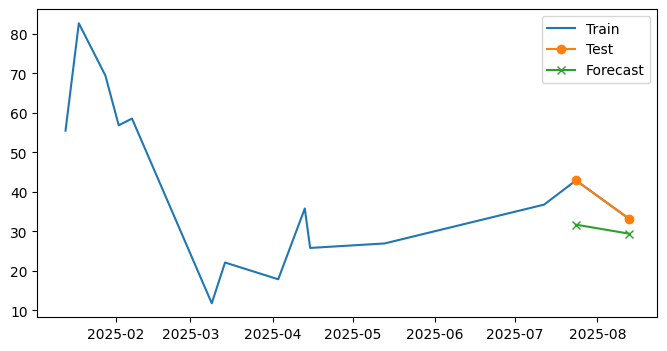

In [116]:
plt.figure(figsize=(8,4))
plt.plot(df.index, df, label="Train")
plt.plot(test.index, test, label="Test", marker="o")
plt.plot(forecast.index, forecast, label="Forecast", marker="x")
plt.legend()
plt.show()